# Flatten to solar day
This example requests data from the data cube, adds a `solar_day` variable.

We can then group by solar day. 

We are assuming there is only one real value for the day, and that by taking the `max` value will throw away data from any overlaps.

We can then perfom statistical functions without having to worry about overlapping/duplicate values distorting the output.

In [1]:
%matplotlib inline
import datacube.api
import datetime
import numpy as np
import xarray

In [2]:
dc = datacube.api.API()

Some helper functions that will eventally make it into the API:

In [3]:
def solar_day(utc, latitude):
    SECONDS_PER_DEGREE = 240
    offset_seconds = int(latitude * SECONDS_PER_DEGREE)
    offset = np.timedelta64(offset_seconds, 's')
    return utc + offset

In [4]:
def get_mean_longitude(dataset):
    x = 'longitude' if 'latitude' in dataset.coords else 'x'
    y = 'latitude' if 'latitude' in dataset.coords else 'y'
    mean_lat = float(dataset[x][0] + dataset[x][-1])/2.
    mean_lon = float(dataset[y][0] + dataset[y][-1])/2.
    bounds = {'left': mean_lon, 'right': mean_lon, 'top': mean_lat, 'bottom': mean_lat}
    from datacube.api._conversion import geospatial_warp_bounds
    ll = geospatial_warp_bounds(bounds, dataset.crs.attrs['spatial_ref'])
    return ll['left']

In [5]:
def add_solar_day(dataset):
    longitude = get_mean_longitude(dataset)
    solar_days = np.array(map(lambda dt: solar_day(dt, longitude), data.time.values)).astype('datetime64[D]')
    data['solar_day'] = xarray.DataArray(solar_days, coords={'time': data.time}, dims=['time'])

In [30]:
cells = dc.list_cells(product='NBAR', latitude=(-35, -36), longitude=(148, 149))
cells

[(14, -41), (14, -40), (15, -41), (15, -40)]

In [46]:
data = dc.get_dataset_by_cell(xy_index=cells, product='NBAR', set_nan=True, time=('1990', '2000'), 
                              latitude=(-35, -36), longitude=(148, 149))
data

<xarray.Dataset>
Dimensions:  (time: 193, x: 4166, y: 4875)
Coordinates:
  * time     (time) datetime64[ns] 1990-03-02T23:11:16 1990-03-02T23:11:39 ...
  * y        (y) float64 -3.913e+06 -3.913e+06 -3.913e+06 -3.913e+06 ...
  * x        (x) float64 1.439e+06 1.439e+06 1.439e+06 1.439e+06 1.439e+06 ...
Data variables:
    crs      int64 0
    band_70  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_10  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_20  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_50  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_40  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_30  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    source: This data is a reprojection and retile of Landsat surface reflectance scene data available from /g/data/rs0/scenes/
    summary: These files are experimental, short li

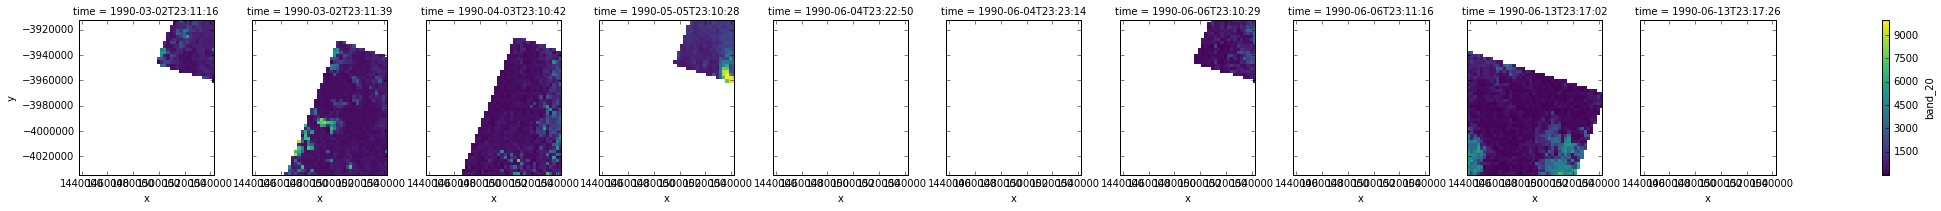

In [47]:
data.band_20[:10,::100,::100].plot.imshow(col='time')

We can now add the `solar_day` variable:

In [42]:
add_solar_day(data)
data

<xarray.Dataset>
Dimensions:    (time: 193, x: 4166, y: 4875)
Coordinates:
  * time       (time) datetime64[ns] 1990-03-02T23:11:16 1990-03-02T23:11:39 ...
  * y          (y) float64 -3.913e+06 -3.913e+06 -3.913e+06 -3.913e+06 ...
  * x          (x) float64 1.439e+06 1.439e+06 1.439e+06 1.439e+06 1.439e+06 ...
Data variables:
    crs        int64 0
    band_70    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_10    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_20    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_50    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_40    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    band_30    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    solar_day  (time) datetime64[ns] 1990-03-03 1990-03-03 1990-04-04 ...
Attributes:
    source: This data is a reprojection and retile of Landsat surface reflectance s

When we group them, we can see how many days out dataset covers:

In [43]:
solar_day_groups = data.groupby('solar_day')
len(solar_day_groups)

106

In [ ]:
data_by_solar_day = solar_day_groups.max(dim='time')
data_by_solar_day

That's still a lot of data to deal with, so lets downsample a bit:

In [35]:
low_res = data_by_solar_day.band_20[:,::100,::100]

Display a thumbnail at every solar day, for some days at least:

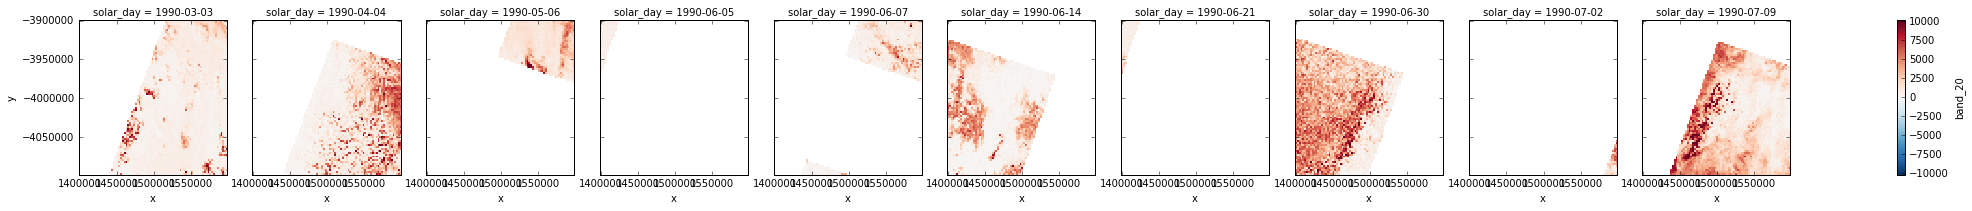

In [36]:
low_res[:10].plot.imshow(col='solar_day')

How much data is in these tiles?

(This will get more interesting once we use cloud masking...)

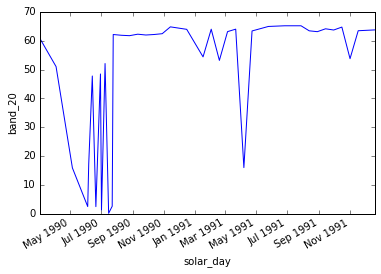

In [37]:
(100 * low_res.count(dim=['x', 'y']) / float(low_res[0].size)).plot()

What areas do we have data for?

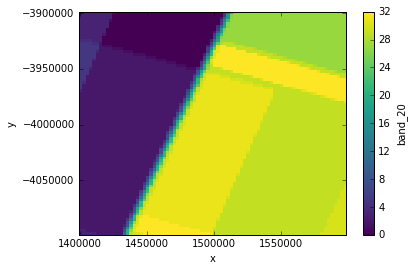

In [38]:
low_res.count(dim='solar_day').plot.imshow()